In [2]:
import warnings
from typing import Any, Dict, ClassVar, Generator, Optional, \
                   Tuple, Union, NamedTuple, Type, TypeVar, Union
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.utils import get_device
from collections import defaultdict
import numpy as np
import torch as th
from gymnasium import spaces
from torch.nn import functional as F
from abc import ABC, abstractmethod
import pandas as pd 
from stable_baselines3.common.evaluation import evaluate_policy
import seaborn as sns 
import matplotlib.pyplot as plt 
import utils 
from gym.spaces import Discrete

from stable_baselines3.common.policies import obs_as_tensor

th.autograd.set_detect_anomaly(True)

# from stable_baselines3.common.buffers import RolloutBuffer
from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance, get_schedule_fn
from stable_baselines3.common.preprocessing import get_action_dim, get_obs_shape

class RolloutBufferSamples(NamedTuple):
    observations: th.Tensor
    actions: th.Tensor
    old_values: th.Tensor
    old_log_prob: th.Tensor
    advantages: th.Tensor
    returns: th.Tensor

SelfPPO = TypeVar("SelfPPO", bound="PPO")

In [14]:
class BaseBuffer(ABC):
    """
    Base class that represent a buffer (rollout or replay)

    :param buffer_size: Max number of element in the buffer
    :param observation_space: Observation space
    :param action_space: Action space
    :param device: PyTorch device
        to which the values will be converted
    :param n_envs: Number of parallel environments
    """

    observation_space: spaces.Space
    obs_shape: Tuple[int, ...]

    def __init__(
        self,
        buffer_size: int,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        device: Union[th.device, str] = "auto",
        n_envs: int = 1,
    ):
        super().__init__()
        self.buffer_size = buffer_size
        self.observation_space = observation_space
        self.action_space = action_space
        self.obs_shape = get_obs_shape(observation_space)  # type: ignore[assignment]

        self.action_dim = get_action_dim(action_space)
        self.pos = 0
        self.full = False
        self.device = get_device(device)
        self.n_envs = n_envs

    @staticmethod
    def swap_and_flatten(arr: np.ndarray) -> np.ndarray:
        """
        Swap and then flatten axes 0 (buffer_size) and 1 (n_envs)
        to convert shape from [n_steps, n_envs, ...] (when ... is the shape of the features)
        to [n_steps * n_envs, ...] (which maintain the order)

        :param arr:
        :return:
        """
        shape = arr.shape
        if len(shape) < 3:
            shape = (*shape, 1)
        return arr.swapaxes(0, 1).reshape(shape[0] * shape[1], *shape[2:])

    def size(self) -> int:
        """
        :return: The current size of the buffer
        """
        if self.full:
            return self.buffer_size
        return self.pos

    def add(self, *args, **kwargs) -> None:
        """
        Add elements to the buffer.
        """
        raise NotImplementedError()

    def extend(self, *args, **kwargs) -> None:
        """
        Add a new batch of transitions to the buffer
        """
        # Do a for loop along the batch axis
        for data in zip(*args):
            self.add(*data)

    def reset(self) -> None:
        """
        Reset the buffer.
        """
        self.pos = 0
        self.full = False

    def sample(self, batch_size: int, env: Optional[VecNormalize] = None):
        """
        :param batch_size: Number of element to sample
        :param env: associated gym VecEnv
            to normalize the observations/rewards when sampling
        :return:
        """
        upper_bound = self.buffer_size if self.full else self.pos
        batch_inds = np.random.randint(0, upper_bound, size=batch_size)
        return self._get_samples(batch_inds, env=env)

    @abstractmethod
    def _get_samples(
        self, batch_inds: np.ndarray, env: Optional[VecNormalize] = None
    ) -> RolloutBufferSamples:
        """
        :param batch_inds:
        :param env:
        :return:
        """
        raise NotImplementedError()

    def to_torch(self, array: np.ndarray, copy: bool = True) -> th.Tensor:
        """
        Convert a numpy array to a PyTorch tensor.
        Note: it copies the data by default

        :param array:
        :param copy: Whether to copy or not the data (may be useful to avoid changing things
            by reference). This argument is inoperative if the device is not the CPU.
        :return:
        """
        if copy:
            return th.tensor(array, device=self.device)
        return th.as_tensor(array, device=self.device)

    @staticmethod
    def _normalize_obs(
        obs: Union[np.ndarray, Dict[str, np.ndarray]],
        env: Optional[VecNormalize] = None,
    ) -> Union[np.ndarray, Dict[str, np.ndarray]]:
        if env is not None:
            return env.normalize_obs(obs)
        return obs

    @staticmethod
    def _normalize_reward(reward: np.ndarray, env: Optional[VecNormalize] = None) -> np.ndarray:
        if env is not None:
            return env.normalize_reward(reward).astype(np.float32)
        return reward

class RolloutBuffer(BaseBuffer):
    """
    Rollout buffer used in on-policy algorithms like A2C/PPO.
    It corresponds to ``buffer_size`` transitions collected
    using the current policy.
    This experience will be discarded after the policy update.
    In order to use PPO objective, we also store the current value of each state
    and the log probability of each taken action.

    The term rollout here refers to the model-free notion and should not
    be used with the concept of rollout used in model-based RL or planning.
    Hence, it is only involved in policy and value function training but not action selection.

    :param buffer_size: Max number of element in the buffer
    :param observation_space: Observation space
    :param action_space: Action space
    :param device: PyTorch device
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        Equivalent to classic advantage when set to 1.
    :param gamma: Discount factor
    :param n_envs: Number of parallel environments
    """

    observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    advantages: np.ndarray
    returns: np.ndarray
    episode_starts: np.ndarray
    log_probs: np.ndarray
    values: np.ndarray

    def __init__(
        self,
        buffer_size: int,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        device: Union[th.device, str] = "auto",
        gae_lambda: float = 1,
        gamma: float = 0.99,
        n_envs: int = 1,
    ):
        super().__init__(buffer_size, observation_space, action_space, device, n_envs=n_envs)
        self.gae_lambda = gae_lambda
        self.gamma = gamma
        self.generator_ready = False
        self.reset()

    def reset(self) -> None:
        self.observations = np.zeros((self.buffer_size, self.n_envs, *self.obs_shape), dtype=np.float32)
        self.actions = np.zeros((self.buffer_size, self.n_envs, self.action_dim), dtype=np.float32)
        self.rewards = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.returns = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.episode_starts = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.values = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.log_probs = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.advantages = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.generator_ready = False
        super().reset()

    def compute_returns_and_advantage(self, last_values: th.Tensor, dones: np.ndarray) -> None:
        """
        Post-processing step: compute the lambda-return (TD(lambda) estimate)
        and GAE(lambda) advantage.

        Uses Generalized Advantage Estimation (https://arxiv.org/abs/1506.02438)
        to compute the advantage. To obtain Monte-Carlo advantage estimate (A(s) = R - V(S))
        where R is the sum of discounted reward with value bootstrap
        (because we don't always have full episode), set ``gae_lambda=1.0`` during initialization.

        The TD(lambda) estimator has also two special cases:
        - TD(1) is Monte-Carlo estimate (sum of discounted rewards)
        - TD(0) is one-step estimate with bootstrapping (r_t + gamma * v(s_{t+1}))

        For more information, see discussion in https://github.com/DLR-RM/stable-baselines3/pull/375.

        :param last_values: state value estimation for the last step (one for each env)
        :param dones: if the last step was a terminal step (one bool for each env).
        """
        # Convert to numpy
        last_values = last_values.clone().cpu().numpy().flatten()

        last_gae_lam = 0
        for step in reversed(range(self.buffer_size)):
            if step == self.buffer_size - 1:
                next_non_terminal = 1.0 - dones
                next_values = last_values
            else:
                next_non_terminal = 1.0 - self.episode_starts[step + 1]
                next_values = self.values[step + 1]
            delta = self.rewards[step] + self.gamma * next_values * next_non_terminal - self.values[step]
            last_gae_lam = delta + self.gamma * self.gae_lambda * next_non_terminal * last_gae_lam
            self.advantages[step] = last_gae_lam
        # TD(lambda) estimator, see Github PR #375 or "Telescoping in TD(lambda)"
        # in David Silver Lecture 4: https://www.youtube.com/watch?v=PnHCvfgC_ZA
        self.returns = self.advantages + self.values

    def add(
        self,
        obs: np.ndarray,
        action: np.ndarray,
        reward: np.ndarray,
        episode_start: np.ndarray,
        value: th.Tensor,
        log_prob: th.Tensor,
    ) -> None:
        """
        :param obs: Observation
        :param action: Action
        :param reward:
        :param episode_start: Start of episode signal.
        :param value: estimated value of the current state
            following the current policy.
        :param log_prob: log probability of the action
            following the current policy.
        """
        if len(log_prob.shape) == 0:
            # Reshape 0-d tensor to avoid error
            log_prob = log_prob.reshape(-1, 1)

        # Reshape needed when using multiple envs with discrete observations
        # as numpy cannot broadcast (n_discrete,) to (n_discrete, 1)
        if isinstance(self.observation_space, spaces.Discrete):
            obs = obs.reshape((self.n_envs, *self.obs_shape))

        # Reshape to handle multi-dim and discrete action spaces, see GH #970 #1392
        action = action.reshape((self.n_envs, self.action_dim))

        self.observations[self.pos] = np.array(obs)
        self.actions[self.pos] = np.array(action)
        self.rewards[self.pos] = np.array(reward)
        self.episode_starts[self.pos] = np.array(episode_start)
        self.values[self.pos] = value.clone().cpu().numpy().flatten()
        self.log_probs[self.pos] = log_prob.clone().cpu().numpy()
        self.pos += 1
        if self.pos == self.buffer_size:
            self.full = True

    def get(self, batch_size: Optional[int] = None) -> Generator[RolloutBufferSamples, None, None]:
        assert self.full, ""
        indices = np.random.permutation(self.buffer_size * self.n_envs)
        # Prepare the data
        if not self.generator_ready:
            _tensor_names = [
                "observations",
                "actions",
                "values",
                "log_probs",
                "advantages",
                "returns",
            ]

            for tensor in _tensor_names:
                self.__dict__[tensor] = self.swap_and_flatten(self.__dict__[tensor])
            self.generator_ready = True

        # Return everything, don't create minibatches
        if batch_size is None:
            batch_size = self.buffer_size * self.n_envs

        start_idx = 0
        while start_idx < self.buffer_size * self.n_envs:
            yield self._get_samples(indices[start_idx : start_idx + batch_size])
            start_idx += batch_size

    def _get_samples(
        self,
        batch_inds: np.ndarray,
        env: Optional[VecNormalize] = None,
    ) -> RolloutBufferSamples:
        data = (
            self.observations[batch_inds],
            self.actions[batch_inds],
            self.values[batch_inds].flatten(),
            self.log_probs[batch_inds].flatten(),
            self.advantages[batch_inds].flatten(),
            self.returns[batch_inds].flatten(),
        )
        return RolloutBufferSamples(*tuple(map(self.to_torch, data)))


class PPO(OnPolicyAlgorithm):
    """
    Proximal Policy Optimization algorithm (PPO) (clip version)

    Paper: https://arxiv.org/abs/1707.06347
    Code: This implementation borrows code from OpenAI Spinning Up (https://github.com/openai/spinningup/)
    https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail and
    Stable Baselines (PPO2 from https://github.com/hill-a/stable-baselines)

    Introduction to PPO: https://spinningup.openai.com/en/latest/algorithms/ppo.html

    :param policy: The policy model to use (MlpPolicy, CnnPolicy, ...)
    :param env: The environment to learn from (if registered in Gym, can be str)
    :param learning_rate: The learning rate, it can be a function
        of the current progress remaining (from 1 to 0)
    :param n_steps: The number of steps to run for each environment per update
        (i.e. rollout buffer size is n_steps * n_envs where n_envs is number of environment copies running in parallel)
        NOTE: n_steps * n_envs must be greater than 1 (because of the advantage normalization)
        See https://github.com/pytorch/pytorch/issues/29372
    :param batch_size: Minibatch size
    :param n_epochs: Number of epoch when optimizing the surrogate loss
    :param gamma: Discount factor
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator
    :param clip_range: Clipping parameter, it can be a function of the current progress
        remaining (from 1 to 0).
    :param clip_range_vf: Clipping parameter for the value function,
        it can be a function of the current progress remaining (from 1 to 0).
        This is a parameter specific to the OpenAI implementation. If None is passed (default),
        no clipping will be done on the value function.
        IMPORTANT: this clipping depends on the reward scaling.
    :param normalize_advantage: Whether to normalize or not the advantage
    :param ent_coef: Entropy coefficient for the loss calculation
    :param vf_coef: Value function coefficient for the loss calculation
    :param max_grad_norm: The maximum value for the gradient clipping
    :param use_sde: Whether to use generalized State Dependent Exploration (gSDE)
        instead of action noise exploration (default: False)
    :param sde_sample_freq: Sample a new noise matrix every n steps when using gSDE
        Default: -1 (only sample at the beginning of the rollout)
    :param rollout_buffer_class: Rollout buffer class to use. If ``None``, it will be automatically selected.
    :param rollout_buffer_kwargs: Keyword arguments to pass to the rollout buffer on creation
    :param target_kl: Limit the KL divergence between updates,
        because the clipping is not enough to prevent large update
        see issue #213 (cf https://github.com/hill-a/stable-baselines/issues/213)
        By default, there is no limit on the kl div.
    :param stats_window_size: Window size for the rollout logging, specifying the number of episodes to average
        the reported success rate, mean episode length, and mean reward over
    :param tensorboard_log: the log location for tensorboard (if None, no logging)
    :param policy_kwargs: additional arguments to be passed to the policy on creation
    :param verbose: Verbosity level: 0 for no output, 1 for info messages (such as device or wrappers used), 2 for
        debug messages
    :param seed: Seed for the pseudo random generators
    :param device: Device (cpu, cuda, ...) on which the code should be run.
        Setting it to auto, the code will be run on the GPU if possible.
    :param _init_setup_model: Whether or not to build the network at the creation of the instance
    """

    policy_aliases: ClassVar[Dict[str, Type[BasePolicy]]] = {
        "MlpPolicy": ActorCriticPolicy,
        "CnnPolicy": ActorCriticCnnPolicy,
        "MultiInputPolicy": MultiInputActorCriticPolicy,
    }

    def __init__(
        self,
        policy: Union[str, Type[ActorCriticPolicy]],
        env: Union[GymEnv, str],
        learning_rate: Union[float, Schedule] = 3e-4,
        n_steps: int = 2048,
        batch_size: int = 64,
        n_epochs: int = 10,
        gamma: float = 0.99,
        gae_lambda: float = 0.95,
        clip_range: Union[float, Schedule] = 0.2,
        clip_range_vf: Union[None, float, Schedule] = None,
        normalize_advantage: bool = True,
        ent_coef: float = 0.0,
        vf_coef: float = 0.5,
        max_grad_norm: float = 0.5,
        use_sde: bool = False,
        sde_sample_freq: int = -1,
        rollout_buffer_class: Optional[Type[RolloutBuffer]] = None,
        rollout_buffer_kwargs: Optional[Dict[str, Any]] = None,
        target_kl: Optional[float] = None,
        stats_window_size: int = 100,
        tensorboard_log: Optional[str] = None,
        policy_kwargs: Optional[Dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[th.device, str] = "auto",
        _init_setup_model: bool = True,
    ):
        super().__init__(
            policy,
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            gamma=gamma,
            gae_lambda=gae_lambda,
            ent_coef=ent_coef,
            vf_coef=vf_coef,
            max_grad_norm=max_grad_norm,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,
            rollout_buffer_class=rollout_buffer_class,
            rollout_buffer_kwargs=rollout_buffer_kwargs,
            stats_window_size=stats_window_size,
            tensorboard_log=tensorboard_log,
            policy_kwargs=policy_kwargs,
            verbose=verbose,
            device=device,
            seed=seed,
            _init_setup_model=False,
            supported_action_spaces=(
                spaces.Box,
                spaces.Discrete,
                spaces.MultiDiscrete,
                spaces.MultiBinary,
            ),
        )

        # Sanity check, otherwise it will lead to noisy gradient and NaN
        # because of the advantage normalization
        if normalize_advantage:
            assert (
                batch_size > 1
            ), "`batch_size` must be greater than 1. See https://github.com/DLR-RM/stable-baselines3/issues/440"

        if self.env is not None:
            # Check that `n_steps * n_envs > 1` to avoid NaN
            # when doing advantage normalization
            buffer_size = self.env.num_envs * self.n_steps
            assert buffer_size > 1 or (
                not normalize_advantage
            ), f"`n_steps * n_envs` must be greater than 1. Currently n_steps={self.n_steps} and n_envs={self.env.num_envs}"
            # Check that the rollout buffer size is a multiple of the mini-batch size
            untruncated_batches = buffer_size // batch_size
            if buffer_size % batch_size > 0:
                warnings.warn(
                    f"You have specified a mini-batch size of {batch_size},"
                    f" but because the `RolloutBuffer` is of size `n_steps * n_envs = {buffer_size}`,"
                    f" after every {untruncated_batches} untruncated mini-batches,"
                    f" there will be a truncated mini-batch of size {buffer_size % batch_size}\n"
                    f"We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.\n"
                    f"Info: (n_steps={self.n_steps} and n_envs={self.env.num_envs})"
                )
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.clip_range = clip_range
        self.clip_range_vf = clip_range_vf
        self.normalize_advantage = normalize_advantage
        self.target_kl = target_kl

        if _init_setup_model:
            self._setup_model()

    def _setup_model(self) -> None:
        super()._setup_model()

        # Initialize schedules for policy/value clipping
        self.clip_range = get_schedule_fn(self.clip_range)
        if self.clip_range_vf is not None:
            if isinstance(self.clip_range_vf, (float, int)):
                assert self.clip_range_vf > 0, "`clip_range_vf` must be positive, " "pass `None` to deactivate vf clipping"

            self.clip_range_vf = get_schedule_fn(self.clip_range_vf)

    def train(self) -> None:
        """
        Update policy using the currently gathered rollout buffer.
        """
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update optimizer learning rate
        self._update_learning_rate(self.policy.optimizer)
        # Compute current clip range
        clip_range = self.clip_range(self._current_progress_remaining)  # type: ignore[operator]
        # Optional: clip range for the value function
        if self.clip_range_vf is not None:
            clip_range_vf = self.clip_range_vf(self._current_progress_remaining)  # type: ignore[operator]

        entropy_losses = []
        pg_losses, value_losses = [], []
        clip_fractions = []

        continue_training = True
        # train for n_epochs epochs

        delay_max = 100

        delay_dict = {}
        for epoch in range(self.n_epochs):
            delay_dict[epoch] = []

        for epoch in range(self.n_epochs): 
            rdm_num = np.random.choice(np.arange(epoch, min(self.n_epochs, epoch + delay_max)))
            delay_dict[rdm_num].append(epoch)  
        
        all_rolloutbuffers_sofar = []

        losses = [] 
        epoch_losses = {}

        for epoch in range(self.n_epochs): 
            epoch_losses[epoch] = []
        

        for epoch in range(self.n_epochs):
            approx_kl_divs = []
            # Do a complete pass on the rollout buffer
            
            total_rollouts = 0 

            for i, rollout_data in enumerate(self.rollout_buffer.get(self.batch_size)):
                # print("rollout_data", rollout_data.size)
                if isinstance(self.action_space, spaces.Discrete):
                    # Convert discrete action from float to long
                    actions = rollout_data.actions.long().flatten()

                # Re-sample the noise matrix because the log_std has changed
                if self.use_sde:
                    self.policy.reset_noise(self.batch_size)

                values, log_prob, entropy = self.policy.evaluate_actions(rollout_data.observations, actions)
                
                values = values.flatten()
                # Normalize advantage
                advantages = rollout_data.advantages
                # Normalization does not make sense if mini batchsize == 1, see GH issue #325
                if self.normalize_advantage and len(advantages) > 1:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                # for rollout_data in delayed: 
                # (1) we need to access the appropriate RolloutBufferSamples according to delays
                all_rolloutbuffers_sofar.append(rollout_data)

            total_rollouts = i + 1


            for k in delay_dict[epoch]: 
                for i in range(total_rollouts):
                    rollout_data = all_rolloutbuffers_sofar[total_rollouts * k + i]
                    actions = rollout_data.actions
                    if isinstance(self.action_space, spaces.Discrete):
                        # Convert discrete action from float to long
                        actions = rollout_data.actions.long().flatten()

                    # Re-sample the noise matrix because the log_std has changed
                    if self.use_sde:
                        self.policy.reset_noise(self.batch_size)

                    values, log_prob, entropy = self.policy.evaluate_actions(rollout_data.observations, actions)
                    values = values.flatten()
                    # Normalize advantage
                    advantages = rollout_data.advantages
                    # Normalization does not make sense if mini batchsize == 1, see GH issue #325
                    if self.normalize_advantage and len(advantages) > 1:
                        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                    #! DELAY
                    delay_rollout = all_rolloutbuffers_sofar[total_rollouts * k + i]

                    # ratio between old and new policy, should be one at the first iteration
                    ratio = th.exp(log_prob - delay_rollout.old_log_prob)

                    # clipped surrogate loss
                    policy_loss_1 = advantages * ratio
                    policy_loss_2 = advantages * th.clamp(ratio, 1 - clip_range, 1 + clip_range)
                    policy_loss = -th.min(policy_loss_1, policy_loss_2).mean()

                    # Logging
                    pg_losses.append(policy_loss.item())
                    clip_fraction = th.mean((th.abs(ratio - 1) > clip_range).float()).item()
                    clip_fractions.append(clip_fraction)

                    if self.clip_range_vf is None:
                        # No clipping
                        values_pred = values
                    else:
                        # Clip the difference between old and new value
                        # NOTE: this depends on the reward scaling
                        values_pred = rollout_data.old_values + th.clamp(
                            values - rollout_data.old_values, -clip_range_vf, clip_range_vf
                        )
                    # Value loss using the TD(gae_lambda) target
                    value_loss = F.mse_loss(rollout_data.returns, values_pred)
                    value_losses.append(value_loss.item())

                    # Entropy loss favor exploration
                    if entropy is None:
                        # Approximate entropy when no analytical form
                        entropy_loss = -th.mean(-log_prob)
                    else:
                        entropy_loss = -th.mean(entropy)

                    entropy_losses.append(entropy_loss.item())

                    loss = policy_loss + self.ent_coef * entropy_loss + self.vf_coef * value_loss


                    # Calculate approximate form of reverse KL Divergence for early stopping
                    # see issue #417: https://github.com/DLR-RM/stable-baselines3/issues/417
                    # and discussion in PR #419: https://github.com/DLR-RM/stable-baselines3/pull/419
                    # and Schulman blog: http://joschu.net/blog/kl-approx.html
                    with th.no_grad():
                        log_ratio = log_prob - rollout_data.old_log_prob
                        approx_kl_div = th.mean((th.exp(log_ratio) - 1) - log_ratio).cpu().numpy()
                        approx_kl_divs.append(approx_kl_div)

                    if self.target_kl is not None and approx_kl_div > 1.5 * self.target_kl:
                        continue_training = False
                        if self.verbose >= 1:
                            print(f"Early stopping at step {epoch} due to reaching max kl: {approx_kl_div:.2f}")
                        break
                    
                    print(f"Loss: {loss.item()}, Epoch: {epoch}, Delay: {k}")
                    losses.append(loss.item())
                    
                    epoch_losses[epoch].append(losses)

                    # Optimization step
                    self.policy.optimizer.zero_grad()
                    loss.backward()
                    # Clip grad norm
                    th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                    self.policy.optimizer.step()

                self._n_updates += 1
                if not continue_training:
                    break            

        losses = np.array(losses)


        actions = [[int(action[0]) for action in rollout.actions.numpy()] for rollout in all_rolloutbuffers_sofar]
        observations = [[int(observation[0]) for observation in rollout.observations.numpy()] for rollout in all_rolloutbuffers_sofar]

        
        np.savez(f"data/trials/losses/dppo_losses_epochs_{self.n_epochs}_delay_{delay_max}", losses=losses, entropy_losses=np.array(entropy_losses), value_losses=np.array(value_losses))

        np.savez(f"data/trials/policies/dppo_policy_epochs_{self.n_epochs}_delay_{delay_max}", policy=self.policy.action_dist.distribution.probs.detach().numpy())

        utils.save_json([observations, actions], f"data/trials/rollouts/dppo_run_rolloutss_{self.n_epochs}_delay_{delay_max}.json")



    def learn(
        self: SelfPPO,
        total_timesteps: int,
        callback: MaybeCallback = None,
        log_interval: int = 1,
        tb_log_name: str = "PPO",
        reset_num_timesteps: bool = True,
        progress_bar: bool = False,
    ) -> SelfPPO:
        return super().learn(
            total_timesteps=total_timesteps,
            callback=callback,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=reset_num_timesteps,
            progress_bar=progress_bar,
        )

# def obs_to_tensor(self, observation: Union[np.ndarray, Dict[str, np.ndarray]]) -> Tuple[PyTorchObs, bool]:
#         """
#         Convert an input observation to a PyTorch tensor that can be fed to a model.
#         Includes sugar-coating to handle different observations (e.g. normalizing images).

#         :param observation: the input observation
#         :return: The observation as PyTorch tensor
#             and whether the observation is vectorized or not
#         """
# import torch 
# print(torch.as_tensor(8))
# print(model.policy.obs_to_tensor((np.asarray([7]), {''})))
# print(obs_as_tensor(np.asarray([6]), model.policy.device))

In [15]:
import sys
import environment
from environment import MDPEnv
from stable_baselines3.common.monitor import Monitor
# import gymnasium as gym 
# from gym import spaces 
# from stable_baselines3.common import policies

# obs_space = spaces.Dict({"a": spaces.Discrete(2,), "b": spaces.Box(0,1,(2,))})
# policy = policies.MultiInputActorCriticPolicy(
#     obs_space,
#     spaces.Discrete(4,),
#     lambda _: 0.001,
# )
# obs = obs_space.sample()
# print(policy.obs_to_tensor(obs))

# sys.exit()

MimicEnv = MDPEnv(environment.config)
MimicEnv = Monitor(MimicEnv, filename='ppo_rewards.csv', allow_early_resets=True)
model = PPO("MlpPolicy", MimicEnv, verbose=1, tensorboard_log="", batch_size = 100,  n_epochs=500, learning_rate = 0.003)
model.learn(total_timesteps=10000)
obs = MimicEnv.reset()
# print(obs)

# mean_reward, std_reward = evaluate_policy(model, MimicEnv, n_eval_episodes=1, deterministic=True)

import numpy as np
from stable_baselines3.common.policies import obs_as_tensor

# obs = obs_as_tensor(1., model.policy.device) 
# print(model.policy) # ActorCriticPolicy
# TensorDict = Dict[str, th.Tensor]
# PyTorchObs = Union[th.Tensor, TensorDict]


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to PPO_59


/var/folders/g_/cwvjv87n3wq590ldrjtpds000000gn/T/ipykernel_80456/3385654285.py:449: UserWarning: You have specified a mini-batch size of 100, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2048`, after every 20 untruncated mini-batches, there will be a truncated mini-batch of size 48
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2048 and n_envs=1)
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 5230 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
Loss: 35376.140625, Epoch: 19, Delay: 18
Loss: 39118.51171875, Epoch: 19, Delay: 18
Loss: 39493.57421875, Epoch: 19, Delay: 18
Loss: 39248.2421875, Epoch: 19, Delay: 18
Loss: 36926.421875, Epoch: 19, Delay: 18
Loss: 37686.33984375, Epoch: 19, Delay: 18
Loss: 39354.2734375, Epoch: 19, Delay: 18
Loss: 39033.64453125, Epoch: 19, Delay: 18
Loss: 35736.82421875, Epoch: 19, Delay: 18
Loss: 37774.53125, Epoch: 19, Delay: 18
Loss: 38623.3515625, Epoch: 19, Delay: 18
Loss: 38255.75390625, Epoch: 19, Delay: 18
Loss: 37354.48828125, Epoch: 19, Delay: 18
Loss: 37558.5625, Epoch: 19, Delay: 18
Loss: 36800.34375, Epoch: 19, Delay: 18
Loss: 37467.703125, Epoch: 19, Delay: 18
Loss: 38230.1640625, Epoch: 19, Delay: 18
Loss: 39067.7890625, Epoch: 19, Delay: 18
Loss: 37126.7109375, Epoch: 19, Delay

FileNotFoundError: [Errno 2] No such file or directory: 'data/trials/losses/dppo_losses_epochs_500_delay_100.npz'

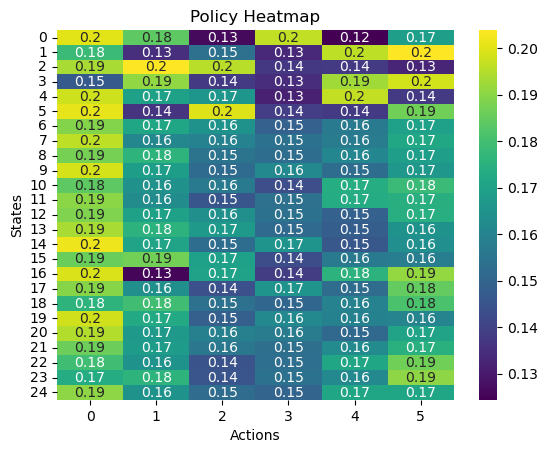

In [16]:
def predict_proba(model, state):
    obs = obs_as_tensor(state, model.policy.device)
    dis = model.policy.get_distribution(obs)
    probs = dis.distribution.probs
    probs_np = probs.detach().numpy()
    return probs_np
# prob = predict_proba(model, np.asarray([12, 13]))
prob = predict_proba(model, np.arange(0,25))

sns.heatmap(prob,  annot=True, cmap="viridis", cbar=True)
# plt.imshow(prob)

plt.xlabel('Actions')
plt.ylabel('States')
plt.title('Policy Heatmap')
plt.savefig('policy_heatmap.png', dpi=400)

plt.show()
# print(f"Mean Reward: {mean_reward}")